# Signal/Noise Benchmarks
This notebook generates figures that demonstrate algorithm performance across a variety of signal/noise values.

## Parameters

In [70]:
POPULATION = 500_000 # population of simulated region
BACKGROUND_INCIDENCE_RATE = 0.005 # e.g., background rate of a disease
CLUSTER_RADIUS_INTERVAL = (0.1, 0.25) # (min, max) radius
QUADTREE_HEIGHT = 4

BETAS = [1.1, 1.5, 2.0, 5.0, 10.0, 100.0] # values of beta (signal factor)
EPSILONS = [0.1, 0.25, 0.5, 1.0, 5.0, "Nonprivate"] # values of epsilon (bound on privacy loss)
ITERS = 1 # number of simulations per (beta, epsilon pair)

SAVE_DATA_PATH = "./signal_noise.csv"

## Data generation
Pick a point $c$ uniformly from the unit square and a radius $r$ from `CLUSTER_RADIUS_INTERVAL`. Designate the circle centered at $c$ with radius $r$ as our cluster region $C$.

Let `lambda_background := POPULATION * BACKGROUND_INCIDENCE_RATE`. Generate points outside of $C$ according to a Poisson point process with rate `lambda_background`.

Let `lambda_cluster := lambda_background * beta` Generate points within $C$ according to a Poisson point process with rate `lambda_cluster`.

What results is a set of points on the unit square representing a simulated dataset where points represent events such as disease incidence.

In [71]:
import numpy as np
import typing
from shapely import geometry

from cormode import Point
from cormode import gen

def generate_dataset(beta: float) -> typing.List[Point]:
    # beta := signal ratio, e.g., ratio of lambda_cluster / lambda_background
    # pick circular region to be our cluster
    cluster_center = (np.random.uniform(0,1), np.random.uniform(0,1))
    cluster_radius = np.random.uniform(0.1, 0.25)
    cluster_region = geometry.Point(*cluster_center).buffer(cluster_radius)

    lambda_background = POPULATION * BACKGROUND_INCIDENCE_RATE
    lambda_cluster = lambda_background * beta

    # generate points randomly
    return gen.generate_points_single_cluster(
        geometry.box(0,0,1,1),
        lambda_background,
        cluster_region,
        lambda_cluster
    ), cluster_region

## Run experiment
For each combination of `["EBP+OLS", "Kulldorff+OLS"], betas, epsilons`, generate `ITERS` sample datasets using signal ratio beta and privatize them with the given epsilon. Report average IoU with ground truth cluster.

In [72]:
import pandas as pd
from shapely import geometry
import util
import collections

import cluster
from cormode import gen, private
from cormode.classical import QuadTreeNode
from cormode import postprocessing

trials = ["EBP", "Kulldorff"]
df = pd.DataFrame(columns=["trial", "beta", "epsilon", "mean_iou"])

for trial in trials:
    for beta in BETAS:
        for epsilon in EPSILONS:
            ious = []
            for iter in range(ITERS):
                points, cluster_region = generate_dataset(beta)
                tree = QuadTreeNode(height=QUADTREE_HEIGHT)

                for point in points:
                    tree.insert_point(point)

                if epsilon != "Nonprivate":
                    # privatize tree
                    private_tree = private.make_private_quadtree(tree, epsilon_total=epsilon, budget_strategy=private.BudgetStrategy.GEOMETRIC)
                    ols_tree = postprocessing.build_ols_tree(private_tree)
                else:
                    # if epsilon = 0 then proceed with nonprivate tree
                    ols_tree = tree
                
                if trial == "Kulldorff":
                    _, computed_region = cluster.find_max_kulldorff_sweep(ols_tree, POPULATION)
                elif trial == "EBP":
                    _, computed_region = cluster.find_max_ebp_sweep(ols_tree, POPULATION * BACKGROUND_INCIDENCE_RATE)
                else:
                    raise NotImplementedError(f"Unknown trial {trial}")

                computed_iou = util.intersection_over_union(cluster_region, util.make_shapely_circle(*computed_region))
                ious.append(computed_iou)
            
            df.loc[len(df)] = [trial, beta, epsilon, np.mean(ious)]


### Save data

In [73]:
if SAVE_DATA_PATH is not None:
    df.to_csv(SAVE_DATA_PATH)

## Generate visualization

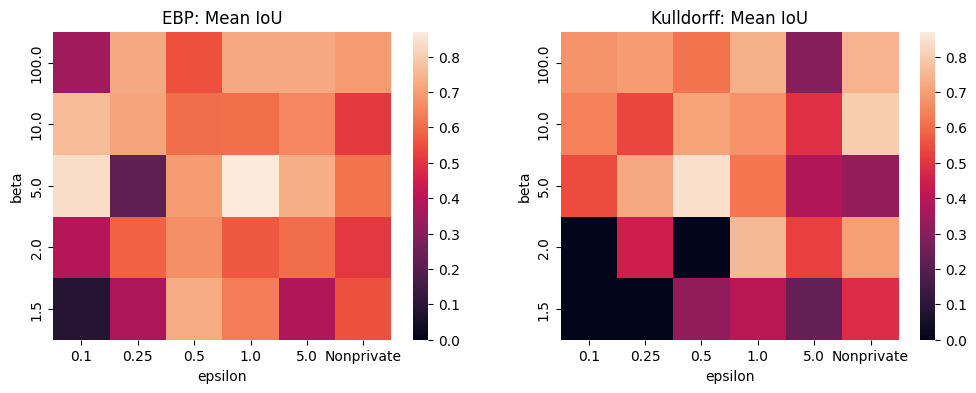

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, len(trials), figsize=(12,4))
vmin, vmax = np.min(df.mean_iou), max(df.mean_iou)

for ax, trial in zip(axs, trials):
    ax.set_title(f"{trial}: Mean IoU")
    df_trial = df[df.trial == trial]
    data = df_trial.pivot("beta", "epsilon", "mean_iou")
    data.sort_index(ascending = False, inplace=True)
    sns.heatmap(data, ax=ax, vmin=vmin, vmax=vmax)